# Predictive Modeling of Race Positions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
import matplotlib as plt
import scipy.stats as ss

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('use_inf_as_na', True)

## Import Data and Scrape Weather Data

In [2]:
# Import all the data
drivers_df = pd.read_csv("./f1db_csv/drivers.csv").drop(columns = "url")
lap_times_df = pd.read_csv("./f1db_csv/lap_times.csv")
results_df = pd.read_csv("./f1db_csv/results.csv")
constructors_df = pd.read_csv("./f1db_csv/constructors.csv")
races = pd.read_csv("./f1db_csv/races.csv")

In [3]:
weather = races.iloc[:,[0,1,2]]

# Scrape data for weather
info = []

for link in races.url:
    try:
        df = pd.read_html(link)[0]
        if 'Weather' in list(df.iloc[:,0]):
            n = list(df.iloc[:,0]).index('Weather')
            info.append(df.iloc[n,1])
        else:
            df = pd.read_html(link)[1]
            if 'Weather' in list(df.iloc[:,0]):
                n = list(df.iloc[:,0]).index('Weather')
                info.append(df.iloc[n,1])
            else:
                df = pd.read_html(link)[2]
                if 'Weather' in list(df.iloc[:,0]):
                    n = list(df.iloc[:,0]).index('Weather')
                    info.append(df.iloc[n,1])
                else:
                    df = pd.read_html(link)[3]
                    if 'Weather' in list(df.iloc[:,0]):
                        n = list(df.iloc[:,0]).index('Weather')
                        info.append(df.iloc[n,1])
                    else:
                        driver = webdriver.Chrome()
                        driver.get(link)

                        # click language button
                        button = driver.find_element_by_link_text('Italiano')
                        button.click()
                        
                        clima = driver.find_element_by_xpath('//*[@id="mw-content-text"]/div/table[1]/tbody/tr[9]/td').text
                        info.append(clima) 
                                
    except:
        info.append('not found')

In [6]:
# Create a df just for weather and clean it up
weather['weather'] = info
weather["weather"].iloc[1021] = "Warm, Sunny"
weather["weather"].iloc[1022] = "Warm, Sunny"
weather["weather"].iloc[1023] = "Warm, Sunny"
weather["weather"].iloc[1024] = "Rain, Cloudy"
weather["weather"].iloc[1025] = "Warm, Sunny"
weather["weather"].iloc[1026] = "Warm, Sunny"

weather_dict = {'weather_warm': ['soleggiato', 'clear', 'warm', 'hot', 'sunny', 'fine', 'mild', 'sereno'],
               'weather_cold': ['cold', 'fresh', 'chilly', 'cool'],
               'weather_dry': ['dry', 'asciutto'],
               'weather_wet': ['showers', 'wet', 'rain', 'pioggia', 'damp', 'thunderstorms', 'rainy'],
               'weather_cloudy': ['overcast', 'nuvoloso', 'clouds', 'cloudy', 'grey', 'coperto']}

weather_df = pd.DataFrame(columns = weather_dict.keys())

for col in weather_df:
    weather_df[col] = weather['weather'].map(lambda x: 1 if any(i in weather_dict[col] for i in x.lower().split()) else 0)

weather_info = pd.concat([weather, weather_df], axis = 1)
weather_info
weather_info.tail(15)

,raceId,year,round,weather,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
1020,1033,2020,3,Partly cloudy,0,0,0,0,1
1021,1034,2020,4,"Warm, Sunny",1,0,0,0,0
1022,1035,2020,5,"Warm, Sunny",1,0,0,0,0
1023,1036,2020,6,"Warm, Sunny",1,0,0,0,0
1024,1037,2020,7,"Rain, Cloudy",0,0,0,0,1
1025,1038,2020,8,"Warm, Sunny",1,0,0,0,0
1026,1039,2020,9,"Warm, Sunny",1,0,0,0,0
1027,1040,2020,10,not found,0,0,0,0,0
1028,1041,2020,11,not found,0,0,0,0,0
1029,1042,2020,12,not found,0,0,0,0,0


In [7]:
# Write this to a csv to be used later
weather_info.to_csv("./f1db_csv/weather.csv")

## Merging with other info for a PM dataset

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

np.set_printoptions(precision=4)

In [9]:
races = pd.read_csv('./f1db_csv/races.csv')
results = pd.read_csv('./f1db_csv/results.csv')
qualifying = pd.read_csv('./f1db_csv/qualifying.csv')
driver_standings = pd.read_csv('./f1db_csv/driver_standings.csv')
constructor_standings = pd.read_csv('./f1db_csv/constructor_standings.csv')
constructors = pd.read_csv('./f1db_csv/constructors.csv')
weather = pd.read_csv('./f1db_csv/weather.csv')
drivers = pd.read_csv('./f1db_csv/drivers.csv')
driver_history = pd.read_csv('./f1db_csv/driver_history.csv')
lap_times = pd.read_csv('./f1db_csv/lap_times.csv')

In [10]:
driver_history.sort_values("raceId")

,Unnamed: 0,driverName,number,nationality,year,name,date,raceId,constructorName,position,minQualifyingTime,racePosition,fastestLapTime,wins,points,driverStanding
7478,7478,Jarno Trulli,NaN,Italian,2009,Australian Grand Prix,2009-03-29,1,Toyota,8,85.265,3.0,88.916,0,6.0,3
7470,7470,Nick Heidfeld,NaN,German,2009,Australian Grand Prix,2009-03-29,1,BMW Sauber,11,85.504,10.0,88.283,0,0.0,10
7476,7476,Sébastien Buemi,NaN,Swiss,2009,Australian Grand Prix,2009-03-29,1,Toro Rosso,16,86.503,7.0,89.230,0,2.0,7
7477,7477,Timo Glock,NaN,German,2009,Australian Grand Prix,2009-03-29,1,Toyota,6,85.281,4.0,88.416,0,5.0,4
7479,7479,Mark Webber,NaN,Australian,2009,Australian Grand Prix,2009-03-29,1,Red Bull,10,85.241,12.0,88.508,0,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7458,7458,Sebastian Vettel,5.0,German,2020,Italian Grand Prix,2020-09-06,1038,Ferrari,17,81.151,NaN,87.107,0,16.0,13
7459,7459,Charles Leclerc,16.0,Monegasque,2020,Italian Grand Prix,2020-09-06,1038,Ferrari,13,80.273,NaN,86.026,0,45.0,7
7460,7460,Kimi Räikkönen,7.0,Finnish,2020,Italian Grand Prix,2020-09-06,1038,Alfa Romeo,14,80.926,13.0,84.835,0,0.0,19
7462,7462,Max Verstappen,33.0,Dutch,2020,Italian Grand Prix,2020-09-06,1038,Red Bull,5,79.780,NaN,85.539,1,110.0,3


In [11]:
# Drop a few columns
# driver_standings.drop(['driver_points_after_race', 'driver_wins_after_race', 'driver_standings_pos_after_race'] ,axis = 1, inplace = True)
# constructor_standings.drop(['constructor_points_after_race', 'constructor_wins_after_race','constructor_standings_pos_after_race' ],axis = 1, inplace = True)

# Merge together to create final df for predictions
df1 = pd.merge(races, weather[["raceId", "weather_warm", "weather_cold", "weather_dry", "weather_wet", "weather_cloudy"]], on=['raceId'])
df2 = pd.merge(df1, results[["raceId", "driverId", "constructorId", "grid", "position", "points", "milliseconds", "laps", "fastestLapSpeed"]], on=['raceId'])
df2 = df2.rename({'position' : 'finishingPosition', 'points' : 'pointsGained'}, axis = 1)
df3 = pd.merge(df2, driver_standings[["raceId", "driverId", "points", "position", "wins"]], on=['raceId', 'driverId'])
df3 = df3.rename({'position' : 'driverStanding', 'points' : 'cumulativePoints', 'wins' : 'driver_wins'}, axis = 1)
df4 = pd.merge(df3, constructor_standings[["raceId", "constructorId", "points", "position", "wins"]], how='left', on=['raceId', 'constructorId']) #from 1958
df4 = df4.rename({'position' : 'constructorStanding', 'points' : 'constructorPoints', 'wins' : 'constructorWins', 'name' : 'raceName'}, axis = 1)
df5 = pd.merge(df4, constructors[["constructorId", "name"]], on = "constructorId")
df5 = df5.rename({'name' : 'constructorName'}, axis = 1)

# Match drivers in driver history table to their driver IDs
drivers["driverName"] = drivers["forename"].str.cat(drivers["surname"],sep = " ")
df6 = pd.merge(driver_history, drivers[["driverName", "driverId"]], on = "driverName")

final_df = pd.merge(df5, df6[["raceId", "driverId", "minQualifyingTime", "fastestLapTime"]], on=['raceId', 'driverId'])
final_df = final_df.drop(columns = ["round", "circuitId", "time", "url", "constructorId"])

# Rearrange the columns so identifying information is at the beginning
key = lambda x: (x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId', x != 'finishingPosition')
final_df = final_df[sorted(final_df, key=key)]

In [12]:
# Get dummies for categorical variables
df_dum = pd.get_dummies(final_df, columns = ['constructorName'])
# Convert date to datetime
df_dum["date"] = pd.to_datetime(df_dum["date"])
df_dum = df_dum.sort_values("date", ascending = True)
df_dum

,raceId,date,year,raceName,driverId,finishingPosition,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,pointsGained,milliseconds,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,minQualifyingTime,fastestLapTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Arrows,constructorName_BAR,constructorName_BMW Sauber,constructorName_Benetton,constructorName_Brawn,constructorName_Caterham,constructorName_Ferrari,constructorName_Footwork,constructorName_Force India,constructorName_Forti,constructorName_HRT,constructorName_Haas F1 Team,constructorName_Honda,constructorName_Jaguar,constructorName_Jordan,constructorName_Ligier,constructorName_Lotus,constructorName_Lotus F1,constructorName_MF1,constructorName_Manor Marussia,constructorName_Marussia,constructorName_McLaren,constructorName_Mercedes,constructorName_Minardi,constructorName_Prost,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Sauber,constructorName_Spyker,constructorName_Spyker MF1,constructorName_Stewart,constructorName_Super Aguri,constructorName_Toro Rosso,constructorName_Toyota,constructorName_Tyrrell,constructorName_Virgin,constructorName_Williams
4972,224,1996-03-10,1996,Australian Grand Prix,49,8,0,0,1,0,0,9,0.0,\N,57,\N,0.0,8,0,0.0,7.0,0.0,94.494,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6031,224,1996-03-10,1996,Australian Grand Prix,44,7,0,0,1,0,0,11,0.0,\N,57,\N,0.0,7,0,0.0,6.0,0.0,95.330,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1069,224,1996-03-10,1996,Australian Grand Prix,35,2,0,0,1,0,0,1,6.0,5608420,58,\N,6.0,2,0,16.0,1.0,1.0,92.371,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1068,224,1996-03-10,1996,Australian Grand Prix,71,1,0,0,1,0,0,2,10.0,5570400,58,\N,10.0,1,1,16.0,1.0,1.0,92.509,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5948,224,1996-03-10,1996,Australian Grand Prix,77,4,0,0,1,0,0,7,3.0,5647437,58,\N,3.0,4,0,3.0,3.0,0.0,94.344,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7427,1038,2020-09-06,2020,Italian Grand Prix,825,\N,1,0,0,0,0,15,0.0,\N,17,243.099,1.0,17,0,1.0,9.0,0.0,80.869,85.787,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6794,1038,2020-09-06,2020,Italian Grand Prix,8,13,1,0,0,0,0,14,0.0,6462368,53,245.827,0.0,19,0,2.0,8.0,0.0,80.926,84.835,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6795,1038,2020-09-06,2020,Italian Grand Prix,841,16,1,0,0,0,0,18,0.0,6481255,53,245.766,2.0,16,0,2.0,8.0,0.0,81.206,84.856,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3875,1038,2020-09-06,2020,Italian Grand Prix,844,\N,1,0,0,0,0,13,0.0,\N,23,242.424,45.0,7,0,61.0,6.0,0.0,80.273,86.026,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Merge lap times data
total_lap_times = pd.merge(lap_times, races[["raceId", "year"]], on = "raceId")
total_lap_times = total_lap_times[["raceId", "driverId", "milliseconds"]]
total_lap_times = total_lap_times.groupby(['raceId', 'driverId']).sum()
total_lap_times["seconds"] = total_lap_times.milliseconds / 1000
total_lap_info = pd.merge(total_lap_times, df_dum[["raceId", "driverId", "laps"]], on = ["raceId", "driverId"])
total_lap_info["avg_lap_time"] = total_lap_info.seconds / total_lap_info.laps
total_lap_info

,raceId,driverId,milliseconds,seconds,laps,avg_lap_time
0,1,2,5662869,5662.869,58,97.635672
1,1,3,5661506,5661.506,58,97.612172
2,1,4,5660663,5660.663,58,97.597638
3,1,7,5662082,5662.082,58,97.622103
4,1,8,5339301,5339.301,55,97.078200
...,...,...,...,...,...,...
7237,1038,844,2127678,2127.678,23,92.507739
7238,1038,846,6432056,6432.056,53,121.359547
7239,1038,847,6462649,6462.649,53,121.936774
7240,1038,848,6463589,6463.589,53,121.954509


## 2020 stuff

**The Process:**

1. Create dummy table for constructors of that year
2. Get total lap time in terms of seconds and merge with dummy table
3. Drop milliseconds
4. Create 2 separate tables for current race info and past race info
5. Merge new table by adding 1 to race ID of previous race

In [44]:
# Merge in the seconds for each race
df_dum_merged = pd.merge(df_dum, total_lap_info, on = ["raceId", "driverId", "laps"])
df_dum_merged = df_dum_merged.drop(columns = ["milliseconds_x", "milliseconds_y"])

# Look only at 2020 data right now
df_2020 = df_dum_merged[df_dum_merged.year == 2020]
# Drop teams that didn't exist in 2020
for col in df_2020.columns:
    if 'constructorName' in col and df_2020[col].sum() < 1:
        df_2020.drop(col, axis = 1, inplace = True)

df_2020 = df_2020.sort_values(["date", "driverId"], ascending = True)
df_2020

,raceId,date,year,raceName,driverId,finishingPosition,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,minQualifyingTime,fastestLapTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,seconds,avg_lap_time
7094,1031,2020-07-05,2020,Austrian Grand Prix,1,4,1,0,0,0,0,5,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,62.951,67.712,0,0,0,0,0,1,0,0,0,0,5456.428,76.851099
7087,1031,2020-07-05,2020,Austrian Grand Prix,8,\N,1,0,0,0,0,19,0.0,53,225.185,0.0,14,0,2.0,7.0,0.0,65.224,69.031,1,0,0,0,0,0,0,0,0,0,3980.856,75.110491
7103,1031,2020-07-05,2020,Austrian Grand Prix,20,10,1,0,0,0,0,11,1.0,71,226.524,1.0,10,0,19.0,3.0,0.0,64.206,68.623,0,0,1,0,0,0,0,0,0,0,5480.284,77.187099
7100,1031,2020-07-05,2020,Austrian Grand Prix,154,\N,1,0,0,0,0,15,0.0,49,221.347,0.0,16,0,0.0,10.0,0.0,64.691,70.228,0,0,0,1,0,0,0,0,0,0,3695.277,75.413816
7085,1031,2020-07-05,2020,Austrian Grand Prix,815,6,1,0,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,63.860,68.305,0,0,0,0,0,0,1,0,0,0,5465.831,76.983535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7240,1038,2020-09-06,2020,Italian Grand Prix,844,\N,1,0,0,0,0,13,0.0,23,242.424,45.0,7,0,61.0,6.0,0.0,80.273,86.026,0,0,1,0,0,0,0,0,0,0,2127.678,92.507739
7231,1038,2020-09-06,2020,Italian Grand Prix,846,4,1,0,0,0,0,6,12.0,53,247.587,57.0,5,0,98.0,3.0,0.0,79.820,84.232,0,0,0,0,1,0,0,0,0,0,6432.056,121.359547
7227,1038,2020-09-06,2020,Italian Grand Prix,847,14,1,0,0,0,0,19,0.0,53,247.033,0.0,21,0,0.0,10.0,0.0,81.587,84.421,0,0,0,0,0,0,0,0,0,1,6462.649,121.936774
7234,1038,2020-09-06,2020,Italian Grand Prix,848,15,1,0,0,0,0,9,0.0,53,245.564,48.0,6,0,158.0,2.0,1.0,80.064,84.926,0,0,0,0,0,0,0,1,0,0,6463.589,121.954509


In [45]:
# Reformat the data so that it's taking info from the previous race
# Separate the data from the current race and the previous race
current_df = df_2020[["raceId", "date", "year", "raceName", "driverId", "seconds", "weather_warm", "weather_cold", 
                      "weather_dry", "weather_wet", "weather_cloudy", "grid", "minQualifyingTime", 
                      "constructorName_Alfa Romeo", "constructorName_AlphaTauri", "constructorName_Ferrari", 
                      "constructorName_Haas F1 Team", "constructorName_McLaren", "constructorName_Mercedes", 
                      "constructorName_Racing Point", "constructorName_Red Bull", "constructorName_Renault", 
                      "constructorName_Williams"]]
past_df = df_2020[["raceId", "date", "year", "raceName", "driverId", "finishingPosition", "pointsGained", 
                   "laps", "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", "constructorPoints", "constructorStanding",
                   "constructorWins", "fastestLapTime", "avg_lap_time"]]

# Change raceId for the past races so that info from the previous race gets matched to the current race for preds
past_df["raceId"] = past_df["raceId"] + 1

# Merge the two together for predictions
full_df = pd.merge(current_df, past_df[["raceId", "driverId", "finishingPosition", "pointsGained", "laps",
                                        "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", 
                                        "constructorPoints", "constructorStanding", "constructorWins", "fastestLapTime"]],
                   on = ["raceId", "driverId"], how = "inner")
full_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,77.825,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,67.712
1,1032,2020-07-12,2020,Styrian Grand Prix,8,5008.802,1,0,0,0,0,16,81.140,1,0,0,0,0,0,0,0,0,0,\N,0.0,53,225.185,0.0,14,0,2.0,7.0,0.0,69.031
2,1032,2020-07-12,2020,Styrian Grand Prix,20,101.037,1,0,0,0,0,10,79.545,0,0,1,0,0,0,0,0,0,0,10,1.0,71,226.524,1.0,10,0,19.0,3.0,0.0,68.623
3,1032,2020-07-12,2020,Styrian Grand Prix,154,5009.618,1,0,0,0,0,0,NaN,0,0,0,1,0,0,0,0,0,0,\N,0.0,49,221.347,0.0,16,0,0.0,10.0,0.0,70.228
4,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,81.607,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,68.305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1038,2020-09-06,2020,Italian Grand Prix,844,2127.678,1,0,0,0,0,13,80.273,0,0,1,0,0,0,0,0,0,0,14,0.0,44,233.813,45.0,5,0,61.0,5.0,0.0,107.840
131,1038,2020-09-06,2020,Italian Grand Prix,846,6432.056,1,0,0,0,0,6,79.820,0,0,0,0,1,0,0,0,0,0,7,6.0,44,232.279,45.0,6,0,68.0,3.0,0.0,108.552
132,1038,2020-09-06,2020,Italian Grand Prix,847,6462.649,1,0,0,0,0,19,81.587,0,0,0,0,0,0,0,0,0,1,\N,0.0,9,225.624,0.0,20,0,0.0,10.0,0.0,111.754
133,1038,2020-09-06,2020,Italian Grand Prix,848,6463.589,1,0,0,0,0,9,80.064,0,0,0,0,0,0,0,1,0,0,6,8.0,44,231.886,48.0,4,0,158.0,2.0,1.0,108.736


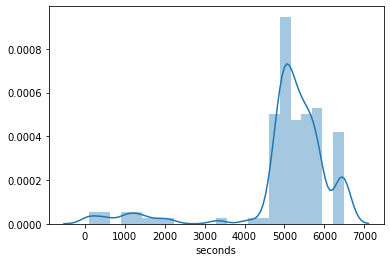

In [17]:
sns.distplot(full_df.seconds)

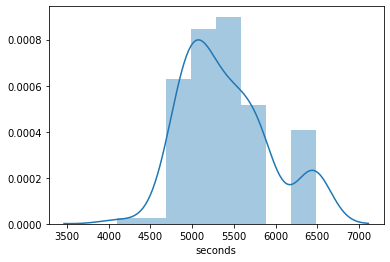

In [18]:
# Cut off the people who finished under 4000 seconds
shortened_df = full_df[full_df.seconds > 4000]
sns.distplot(shortened_df.seconds)

In [19]:
shortened_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,77.825,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,67.712
1,1032,2020-07-12,2020,Styrian Grand Prix,8,5008.802,1,0,0,0,0,16,81.140,1,0,0,0,0,0,0,0,0,0,\N,0.0,53,225.185,0.0,14,0,2.0,7.0,0.0,69.031
3,1032,2020-07-12,2020,Styrian Grand Prix,154,5009.618,1,0,0,0,0,0,NaN,0,0,0,1,0,0,0,0,0,0,\N,0.0,49,221.347,0.0,16,0,0.0,10.0,0.0,70.228
4,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,81.607,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,68.305
5,1032,2020-07-12,2020,Styrian Grand Prix,817,5033.274,1,0,0,0,0,8,79.229,0,0,0,0,0,0,0,0,1,0,\N,0.0,17,220.150,0.0,19,0,4.0,6.0,0.0,70.610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1038,2020-09-06,2020,Italian Grand Prix,842,6426.056,1,0,0,0,0,10,79.909,0,1,0,0,0,0,0,0,0,0,8,4.0,44,233.815,18.0,12,0,20.0,7.0,0.0,107.839
131,1038,2020-09-06,2020,Italian Grand Prix,846,6432.056,1,0,0,0,0,6,79.820,0,0,0,0,1,0,0,0,0,0,7,6.0,44,232.279,45.0,6,0,68.0,3.0,0.0,108.552
132,1038,2020-09-06,2020,Italian Grand Prix,847,6462.649,1,0,0,0,0,19,81.587,0,0,0,0,0,0,0,0,0,1,\N,0.0,9,225.624,0.0,20,0,0.0,10.0,0.0,111.754
133,1038,2020-09-06,2020,Italian Grand Prix,848,6463.589,1,0,0,0,0,9,80.064,0,0,0,0,0,0,0,1,0,0,6,8.0,44,231.886,48.0,4,0,158.0,2.0,1.0,108.736


In [20]:
# Delete rows where there are nans
shortened_df = shortened_df.replace({r"\N": None})
shortened_df = shortened_df.dropna()

# Create ratios for all the variables in terms of seconds and then create a rolling average for them over the season
min_df = shortened_df.groupby("raceId", as_index = False)
min_lap_time = min_df.fastestLapTime.min()
temp1 = pd.merge(shortened_df, min_lap_time, on = "raceId")  
temp1["fastestLapRatio"] = temp1["fastestLapTime_x"] / temp1["fastestLapTime_y"]
temp1 = temp1.drop(columns = ["fastestLapTime_x", "fastestLapTime_y"])
min_quali_time = min_df.minQualifyingTime.min()
temp2 = pd.merge(temp1, min_quali_time, on = "raceId")
temp2["minQualiRatio"] = temp2["minQualifyingTime_x"] / temp2["minQualifyingTime_y"]
temp2 = temp2.drop(columns = ["minQualifyingTime_x", "minQualifyingTime_y"])
temp2["avg_lap_time"] = temp2["seconds"] / temp2["laps"]
temp_min = temp2.groupby("raceId", as_index = False)
min_avg_lap_time = temp_min.avg_lap_time.min()
temp_min1 = pd.merge(temp2, min_avg_lap_time, on = "raceId")
temp_min1["avgLapRatio"] = temp_min1["avg_lap_time_x"] / temp_min1["avg_lap_time_y"]
temp_min1 = temp_min1.drop(columns = ["avg_lap_time_x", "avg_lap_time_y"])
temp3 = temp_min1.groupby("driverId", as_index = True)
rolling_fastLapRatio = pd.DataFrame(temp3["fastestLapRatio"].rolling(window = 50, min_periods = 1).mean())
rolling_fastLapRatio = rolling_fastLapRatio.reset_index()
rolling_fastLapRatio = rolling_fastLapRatio.rename({"level_1" : "index", "fastestLapRatio" : "rolling_fastestLap"}, axis = 1)
rolling_minQualiRatio = pd.DataFrame(temp3["minQualiRatio"].rolling(window = 50, min_periods = 1).mean())
rolling_minQualiRatio = rolling_minQualiRatio.reset_index()
rolling_minQualiRatio = rolling_minQualiRatio.rename({"level_1" : "index", "minQualiRatio" : "rolling_minQualiRatio"}, axis = 1)
rolling_avgLapRatio = pd.DataFrame(temp3["avgLapRatio"].rolling(window = 50, min_periods = 1).mean())
rolling_avgLapRatio = rolling_avgLapRatio.reset_index()
rolling_avgLapRatio = rolling_avgLapRatio.rename({"level_1" : "index", "avgLapRatio" : "rolling_avgLapTime"}, axis = 1)
temp_min1 = temp_min1.reset_index()
temp4 = pd.merge(temp_min1, rolling_fastLapRatio, on = ["driverId", "index"])
temp5 = pd.merge(temp4, rolling_minQualiRatio, on = ["driverId", "index"])
temp6 = pd.merge(temp5, rolling_avgLapRatio, on = ["driverId", "index"])
temp6 = temp6.drop(columns = ["fastestLapRatio", "minQualiRatio", "avgLapRatio", "seconds", "laps"])

key = lambda x: (x != 'index', x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId', x != 'rolling_avgLapTime')
sorted_df = temp6[sorted(temp6, key=key)]
sorted_df["rolling_avgLapTime"] = sorted_df["rolling_avgLapTime"] * 100
sorted_df["rolling_fastestLap"] = sorted_df["rolling_fastestLap"] * 100
sorted_df["rolling_minQualiRatio"] = sorted_df["rolling_minQualiRatio"] * 100
sorted_df

,index,raceId,date,year,raceName,driverId,rolling_avgLapTime,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,rolling_fastestLap,rolling_minQualiRatio
0,0,1032,2020-07-12,2020,Styrian Grand Prix,1,100.000000,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,4,12.0,229.572,12.0,4,0,37.0,1.0,1.0,100.351241,100.000000
1,1,1032,2020-07-12,2020,Styrian Grand Prix,815,101.255099,1,0,0,0,0,17,0,0,0,0,0,0,1,0,0,0,6,8.0,227.579,8.0,6,0,8.0,4.0,0.0,101.230085,104.859621
2,2,1032,2020-07-12,2020,Styrian Grand Prix,822,100.275998,1,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,1,25.0,229.758,25.0,1,1,37.0,1.0,1.0,100.269730,101.069065
3,3,1032,2020-07-12,2020,Styrian Grand Prix,826,103.524779,1,0,0,0,0,13,0,1,0,0,0,0,0,0,0,0,12,0.0,224.847,0.0,12,0,6.0,5.0,0.0,102.460170,102.431095
4,4,1032,2020-07-12,2020,Styrian Grand Prix,832,100.383106,1,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,5,10.0,228.687,10.0,5,0,26.0,2.0,0.0,100.739533,100.982975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,101,1038,2020-09-06,2020,Italian Grand Prix,840,108.078978,1,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,9,2.0,231.036,42.0,7,0,66.0,4.0,0.0,103.251259,101.408699
102,102,1038,2020-09-06,2020,Italian Grand Prix,842,109.739444,1,0,0,0,0,10,0,1,0,0,0,0,0,0,0,0,8,4.0,233.815,18.0,12,0,20.0,7.0,0.0,102.587508,101.433480
103,103,1038,2020-09-06,2020,Italian Grand Prix,846,107.342480,1,0,0,0,0,6,0,0,0,0,1,0,0,0,0,0,7,6.0,232.279,45.0,6,0,68.0,3.0,0.0,102.720987,101.583581
104,104,1038,2020-09-06,2020,Italian Grand Prix,848,108.069107,1,0,0,0,0,9,0,0,0,0,0,0,0,1,0,0,6,8.0,231.886,48.0,4,0,158.0,2.0,1.0,102.419059,101.907965


In [21]:
# Split x and y in training data
x = sorted_df.iloc[:, 7:]
x["fastestLapSpeed"] = pd.to_numeric(x["fastestLapSpeed"])
x["finishingPosition"] = pd.to_numeric(x["finishingPosition"])
y = sorted_df.iloc[:, 6]

### Creating the Test Data

In [22]:
# Doing the same for the most recent race, pulled in from Raw Predictive Modeling ipynb
be_df = pd.read_csv("./predictions/tu_2020_raw_table").iloc[:, 1:]
past_race_lap_info = total_lap_info[total_lap_info.raceId == 1038]
past_race_lap_info["raceId"] = past_race_lap_info["raceId"] + 1
past_race_lap_info
be_merged_df = pd.merge(be_df, past_race_lap_info[["raceId", "driverId", "seconds"]], on = ["raceId", "driverId"])
be_merged_df

,raceId,driverId,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime,seconds
0,1039,1,1,0,0,0,0,1,75.144,0,0,0,0,0,1,0,0,0,0,7.0,7.0,53,252.033,164.0,1,5,281.0,1.0,6.0,82.746,6443.301
1,1039,822,1,0,0,0,0,2,75.203,0,0,0,0,0,1,0,0,0,0,5.0,10.0,53,248.386,117.0,2,1,281.0,1.0,6.0,83.961,6433.164
2,1039,830,1,0,0,0,0,3,75.471,0,0,0,0,0,0,0,1,0,0,NaN,0.0,30,243.804,110.0,3,1,158.0,2.0,1.0,85.539,4499.415
3,1039,848,1,0,0,0,0,4,75.914,0,0,0,0,0,0,0,1,0,0,15.0,0.0,53,245.564,48.0,6,0,158.0,2.0,1.0,84.926,6463.589
4,1039,844,1,0,0,0,0,5,76.270,0,0,1,0,0,0,0,0,0,0,NaN,0.0,23,242.424,45.0,7,0,61.0,6.0,0.0,86.026,2127.678
5,1039,20,1,0,0,0,0,14,76.858,0,0,1,0,0,0,0,0,0,0,NaN,0.0,6,239.415,16.0,13,0,61.0,6.0,0.0,87.107,588.850
6,1039,815,1,0,0,0,0,6,76.311,0,0,0,0,0,0,1,0,0,0,10.0,1.0,53,247.282,34.0,11,0,82.0,4.0,0.0,84.336,6449.280
7,1039,840,1,0,0,0,0,7,76.271,0,0,0,0,0,0,1,0,0,0,3.0,15.0,53,248.576,57.0,4,0,82.0,4.0,0.0,83.897,6429.414
8,1039,817,1,0,0,0,0,8,76.243,0,0,0,0,0,0,0,0,1,0,6.0,8.0,53,248.573,41.0,10,0,71.0,5.0,0.0,83.898,6434.447
9,1039,839,1,0,0,0,0,10,76.297,0,0,0,0,0,0,0,0,1,0,8.0,4.0,53,246.831,30.0,12,0,71.0,5.0,0.0,84.490,6444.747


In [24]:
current_min_df = be_merged_df.groupby("raceId", as_index = False)
current_min_lap_time = current_min_df.fastestLapTime.min()
current_temp1 = pd.merge(be_merged_df, current_min_lap_time, on = "raceId")  
current_temp1["fastestLapRatio"] = current_temp1["fastestLapTime_x"] / current_temp1["fastestLapTime_y"]
current_temp1 = current_temp1.drop(columns = ["fastestLapTime_x", "fastestLapTime_y"])
current_min_quali_time = current_min_df.minQualifyingTime.min()
current_temp2 = pd.merge(current_temp1, current_min_quali_time, on = "raceId")
current_temp2["minQualiRatio"] = current_temp2["minQualifyingTime_x"] / current_temp2["minQualifyingTime_y"]
current_temp2 = current_temp2.drop(columns = ["minQualifyingTime_x", "minQualifyingTime_y"])
current_temp2["avg_lap_time"] = current_temp2["seconds"] / current_temp2["laps"]
current_temp_min = current_temp2.groupby("raceId", as_index = False)
current_min_avg_lap_time = current_temp_min.avg_lap_time.min()
current_temp_min1 = pd.merge(current_temp2, current_min_avg_lap_time, on = "raceId")
current_temp_min1["avgLapRatio"] = current_temp_min1["avg_lap_time_x"] / current_temp_min1["avg_lap_time_y"]
current_temp_min1 = current_temp_min1.drop(columns = ["avg_lap_time_x", "avg_lap_time_y"])
current_temp3 = current_temp_min1.groupby("driverId", as_index = True)
current_rolling_fastLapRatio = pd.DataFrame(current_temp3["fastestLapRatio"].rolling(window = 50, min_periods = 1).mean())
current_rolling_fastLapRatio = current_rolling_fastLapRatio.reset_index()
current_rolling_fastLapRatio = current_rolling_fastLapRatio.rename({"level_1" : "index", "fastestLapRatio" : "rolling_fastestLap"}, axis = 1)
current_rolling_minQualiRatio = pd.DataFrame(current_temp3["minQualiRatio"].rolling(window = 50, min_periods = 1).mean())
current_rolling_minQualiRatio = current_rolling_minQualiRatio.reset_index()
current_rolling_minQualiRatio = current_rolling_minQualiRatio.rename({"level_1" : "index", "minQualiRatio" : "rolling_minQualiRatio"}, axis = 1)
current_rolling_avgLapRatio = pd.DataFrame(current_temp3["avgLapRatio"].rolling(window = 50, min_periods = 1).mean())
current_rolling_avgLapRatio = current_rolling_avgLapRatio.reset_index()
current_rolling_avgLapRatio = current_rolling_avgLapRatio.rename({"level_1" : "index", "avgLapRatio" : "rolling_avgLapTime"}, axis = 1)
current_temp_min1 = current_temp_min1.reset_index()
current_temp4 = pd.merge(current_temp_min1, current_rolling_fastLapRatio, on = ["driverId", "index"])
current_temp5 = pd.merge(current_temp4, current_rolling_minQualiRatio, on = ["driverId", "index"])
current_temp6 = pd.merge(current_temp5, current_rolling_avgLapRatio, on = ["driverId", "index"])
current_temp6 = current_temp6.drop(columns = ["fastestLapRatio", "minQualiRatio", "avgLapRatio", "seconds", "laps"])

key = lambda x: (x != 'index', x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId', x != 'rolling_avgLapTime')
current_sorted_df = current_temp6[sorted(current_temp6, key=key)]
current_sorted_df["rolling_avgLapTime"] = current_sorted_df["rolling_avgLapTime"] * 100
current_sorted_df["rolling_fastestLap"] = current_sorted_df["rolling_fastestLap"] * 100
current_sorted_df["rolling_minQualiRatio"] = current_sorted_df["rolling_minQualiRatio"] * 100
current_sorted_df = current_sorted_df.dropna()
current_sorted_df

,index,raceId,driverId,rolling_avgLapTime,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,rolling_fastestLap,rolling_minQualiRatio
0,0,1039,1,136.340434,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,7.0,7.0,252.033,164.0,1,5,281.0,1.0,6.0,100.000000,100.000000
1,1,1039,822,136.125934,1,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,5.0,10.0,248.386,117.0,2,1,281.0,1.0,6.0,101.468349,100.078516
3,3,1039,848,136.769728,1,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,15.0,0.0,245.564,48.0,6,0,158.0,2.0,1.0,102.634568,101.024699
6,6,1039,815,136.466949,1,0,0,0,0,6,0,0,0,0,0,0,1,0,0,0,10.0,1.0,247.282,34.0,11,0,82.0,4.0,0.0,101.921543,101.553018
7,7,1039,840,136.046584,1,0,0,0,0,7,0,0,0,0,0,0,1,0,0,0,3.0,15.0,248.576,57.0,4,0,82.0,4.0,0.0,101.391004,101.499787
8,8,1039,817,136.153083,1,0,0,0,0,8,0,0,0,0,0,0,0,0,1,0,6.0,8.0,248.573,41.0,10,0,71.0,5.0,0.0,101.392212,101.462525
9,9,1039,839,136.371031,1,0,0,0,0,10,0,0,0,0,0,0,0,0,1,0,8.0,4.0,246.831,30.0,12,0,71.0,5.0,0.0,102.107655,101.534387
10,10,1039,832,135.984310,1,0,0,0,0,9,0,0,0,0,1,0,0,0,0,0,2.0,18.0,248.620,41.0,9,0,98.0,3.0,0.0,101.372876,101.833812
11,11,1039,846,136.102489,1,0,0,0,0,11,0,0,0,0,1,0,0,0,0,0,4.0,12.0,247.587,57.0,5,0,98.0,3.0,0.0,101.795857,101.990844
12,12,1039,826,136.445451,1,0,0,0,0,12,0,1,0,0,0,0,0,0,0,0,9.0,2.0,246.863,4.0,15,0,47.0,7.0,1.0,102.094361,102.275631


In [25]:
x_test = current_sorted_df.iloc[:, 4:]

### Linear Regression

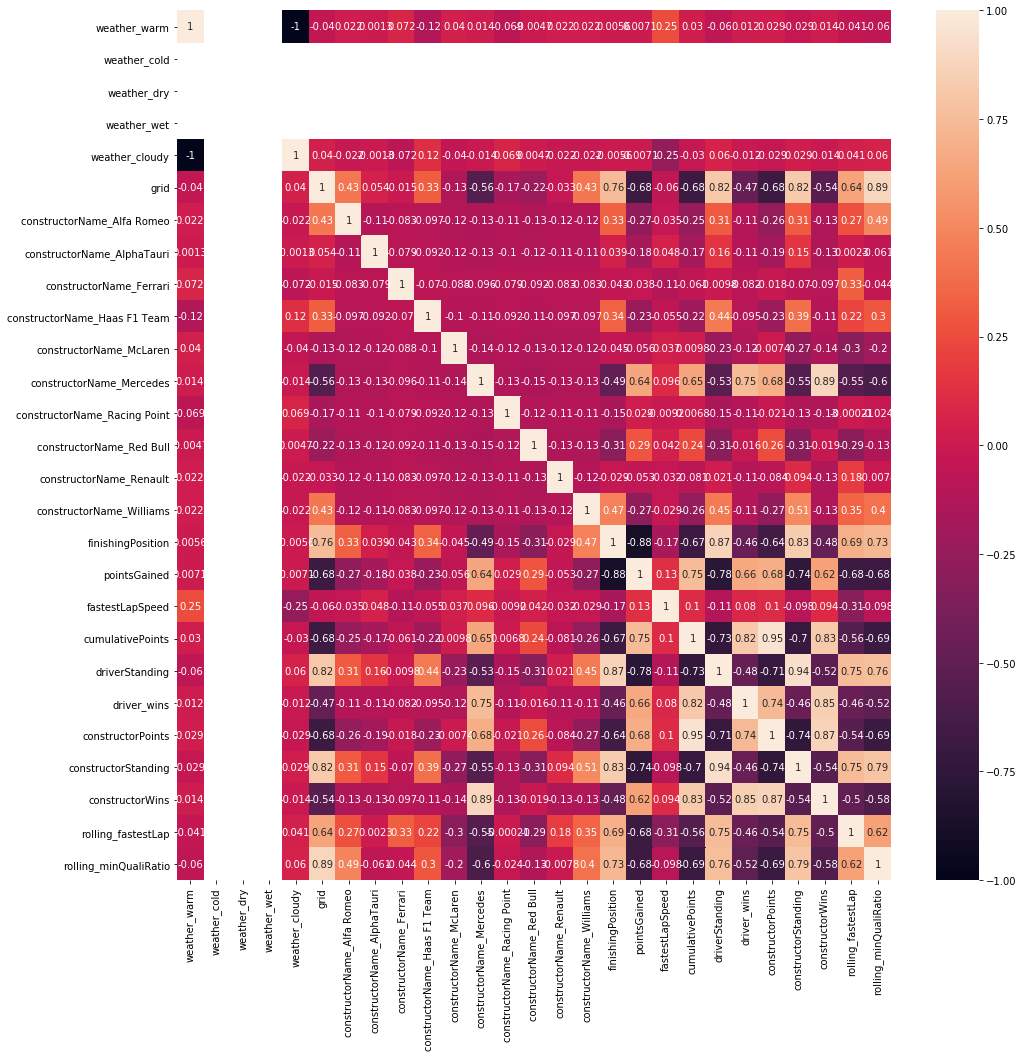

In [26]:
# Check for correlation among the variables
corrMatrix = x.corr()
pyplot.figure(figsize=(16, 16))
sns.heatmap(corrMatrix, annot=True)

In [27]:
# correlated_features = set()

# for i in range(len(corrMatrix.columns)):
#     for j in range(i):
#         if abs(corrMatrix.iloc[i, j]) > 0.8:
#             colname = corrMatrix.columns[i]
#             correlated_features.add(colname)

# correlated_features

In [28]:
# # Remove correlated features from the model
# x = x.drop(labels = correlated_features, axis=1)
# test_x = test_x.drop(labels = correlated_features, axis=1)

In [29]:
lr_model = LinearRegression()
lr_model.fit(x, y)
lr_model.score(x, y)

0.3732655327339477

In [30]:
# Predict based on the model with linear regression
lr_preds = lr_model.predict(x_test)
lr_preds_df = pd.DataFrame({'Predictions' : lr_preds})
merged_lr_df = pd.merge(lr_preds_df, current_sorted_df[["raceId", "driverId"]], left_index = True, right_index = True)
full_lr_df = pd.merge(merged_lr_df, drivers[["driverName", "driverId"]], on = "driverId")
full_lr_df.sort_values("Predictions")

,Predictions,raceId,driverId,driverName
7,103.284537,1039,832,Carlos Sainz
9,104.211559,1039,826,Daniil Kvyat
1,104.866156,1039,822,Valtteri Bottas
0,104.994645,1039,1,Lewis Hamilton
5,105.037730,1039,817,Daniel Ricciardo
10,105.422621,1039,842,Pierre Gasly
8,105.685967,1039,846,Lando Norris
6,106.111768,1039,839,Esteban Ocon
12,106.297595,1039,841,Antonio Giovinazzi
3,106.519018,1039,815,Sergio Pérez


In [31]:
lr_coef_df = pd.DataFrame({"Variables" : x_test.columns, "Coefficients" : lr_model.coef_})
lr_coef_df["abs_coefficients"] = np.abs(lr_coef_df.Coefficients)
lr_coef_df.sort_values("abs_coefficients", ascending = False)

,Variables,Coefficients,abs_coefficients
11,constructorName_Mercedes,2.749970e+00,2.749970e+00
24,constructorWins,-2.108178e+00,2.108178e+00
9,constructorName_Haas F1 Team,-2.035820e+00,2.035820e+00
15,constructorName_Williams,-1.394371e+00,1.394371e+00
12,constructorName_Racing Point,1.364353e+00,1.364353e+00
23,constructorStanding,8.257365e-01,8.257365e-01
4,weather_cloudy,-6.388259e-01,6.388259e-01
0,weather_warm,6.388259e-01,6.388259e-01
25,rolling_fastestLap,-6.141562e-01,6.141562e-01
6,constructorName_Alfa Romeo,-5.224604e-01,5.224604e-01


### Random Forest

In [32]:
# Random Forest regression on this data to predict results for the 2020 Spanish Grand Prix
model = RandomForestRegressor(n_estimators = 300, max_depth = 9, random_state = 1)
model.fit(x, y)
model.score(x, y)

0.8769408725819989

In [33]:
# Predict on x_test
sp_preds = model.predict(x_test)
sp_preds_df = pd.DataFrame({'Predictions' : sp_preds})
merged_sp_df = pd.merge(sp_preds_df, current_sorted_df[["raceId", "driverId"]], left_index = True, right_index = True)
full_sp_df = pd.merge(merged_sp_df, drivers[["driverName", "driverId"]], on = "driverId")
full_sp_df.sort_values("Predictions")

,Predictions,raceId,driverId,driverName
5,102.900578,1039,817,Daniel Ricciardo
4,102.989671,1039,840,Lance Stroll
2,103.190635,1039,848,Alexander Albon
9,103.294693,1039,826,Daniil Kvyat
7,103.436104,1039,832,Carlos Sainz
6,103.554413,1039,839,Esteban Ocon
3,103.660613,1039,815,Sergio Pérez
10,104.525499,1039,842,Pierre Gasly
1,104.546170,1039,822,Valtteri Bottas
12,104.990882,1039,841,Antonio Giovinazzi


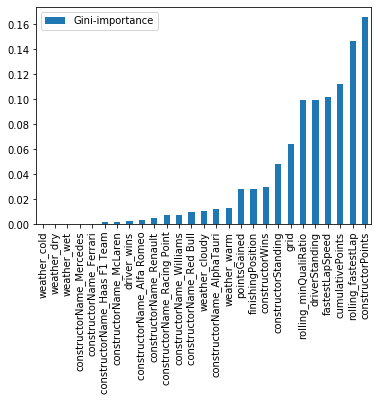

In [34]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)

In [35]:
importances.sort_values("Gini-importance", ascending = False).head(10)

,Gini-importance
constructorPoints,0.165684
rolling_fastestLap,0.146648
cumulativePoints,0.112303
fastestLapSpeed,0.101895
driverStanding,0.099450
rolling_minQualiRatio,0.099421
grid,0.064532
constructorStanding,0.048399
constructorWins,0.030147
finishingPosition,0.028381


### XGBoost

In [36]:
xgb_model = xgb.XGBRegressor(n_estimators = 300, max_depth = 9)
xgb_model.fit(x, y)
xgb_model.score(x, y)

0.9999999279739118

In [37]:
xgb_preds = xgb_model.predict(x_test)
xgb_preds_df = pd.DataFrame({'Predictions' : xgb_preds})
merged_xgb_df = pd.merge(xgb_preds_df, current_sorted_df[["raceId", "driverId"]], left_index = True, right_index = True)
full_xgb_df = pd.merge(merged_xgb_df, drivers[["driverName", "driverId"]], on = "driverId")
full_xgb_df = full_xgb_df.sort_values("Predictions")
full_xgb_df = full_xgb_df.reset_index(drop = True)
full_xgb_df["Predicted Position"] = full_xgb_df.index + 1
full_xgb_df

,Predictions,raceId,driverId,driverName,Predicted Position
0,100.640800,1039,840,Lance Stroll,1
1,100.690643,1039,815,Sergio Pérez,2
2,100.755402,1039,848,Alexander Albon,3
3,101.226334,1039,1,Lewis Hamilton,4
4,101.358757,1039,817,Daniel Ricciardo,5
5,101.458412,1039,822,Valtteri Bottas,6
6,101.545242,1039,839,Esteban Ocon,7
7,101.706207,1039,842,Pierre Gasly,8
8,101.731728,1039,8,Kimi Räikkönen,9
9,102.452240,1039,826,Daniil Kvyat,10


In [59]:
# Save this into a CSV
be_2020_pr_predictions = full_xgb_df[["Predicted Position", "driverName"]]
be_2020_pr_predictions = be_2020_pr_predictions.rename({"driverName" : "Driver Name"})
be_2020_pr_predictions.to_csv("./predictions/be_2020_pr_predictions.csv")

# Predictions on the Unprocessed Dataframe with Raw Seconds

In [208]:
shortened_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,77.825,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,67.712
4,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,81.607,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,68.305
6,1032,2020-07-12,2020,Styrian Grand Prix,822,4984.402,1,0,0,0,0,4,78.657,0,0,0,0,0,1,0,0,0,0,1,25.0,71,229.758,25.0,1,1,37.0,1.0,1.0,67.657
8,1032,2020-07-12,2020,Styrian Grand Prix,826,5000.934,1,0,0,0,0,13,79.717,0,1,0,0,0,0,0,0,0,0,12,0.0,69,224.847,0.0,12,0,6.0,5.0,0.0,69.135
10,1032,2020-07-12,2020,Styrian Grand Prix,832,4989.726,1,0,0,0,0,3,78.590,0,0,0,0,1,0,0,0,0,0,5,10.0,71,228.687,10.0,5,0,26.0,2.0,0.0,67.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1036,2020-08-16,2020,Spanish Grand Prix,844,3331.636,1,0,0,0,0,9,76.953,0,0,1,0,0,0,0,0,0,0,4,12.0,52,234.203,45.0,4,0,55.0,3.0,0.0,90.552
93,1036,2020-08-16,2020,Spanish Grand Prix,846,5546.154,1,0,0,0,0,8,77.084,0,0,0,0,1,0,0,0,0,0,9,2.0,52,233.826,38.0,5,0,53.0,4.0,0.0,90.698
94,1036,2020-08-16,2020,Spanish Grand Prix,847,5584.656,1,0,0,0,0,18,78.099,0,0,0,0,0,0,0,0,0,1,18,0.0,51,232.010,0.0,20,0,0.0,10.0,0.0,91.408
95,1036,2020-08-16,2020,Spanish Grand Prix,848,5545.008,1,0,0,0,0,6,77.029,0,0,0,0,0,0,0,1,0,0,5,10.0,52,237.017,36.0,6,0,113.0,2.0,1.0,89.477


In [221]:
unp_training_df = shortened_df[shortened_df.raceId != 1036]
unp_test_df = shortened_df[shortened_df.raceId == 1036]

# Split into x and y
unp_x = unp_training_df.iloc[:, 6:]
unp_y = unp_training_df.iloc[:, 5]
unp_x["fastestLapSpeed"] = pd.to_numeric(unp_x["fastestLapSpeed"])
unp_x["finishingPosition"] = pd.to_numeric(unp_x["finishingPosition"])

# Same for the test data
unp_test_x = unp_test_df.iloc[:, 6:]
unp_test_y = unp_test_df.iloc[:, 5]
unp_test_x["fastestLapSpeed"] = pd.to_numeric(unp_test_x["fastestLapSpeed"])
unp_test_x["finishingPosition"] = pd.to_numeric(unp_test_x["finishingPosition"])

### Linear Regression

In [222]:
lr_model.fit(unp_x, unp_y)
lr_model.score(unp_x, unp_y)

0.9980497802846171

In [223]:
# Predict based on the model with linear regression
lr_preds = lr_model.predict(unp_test_x)
lr_preds_df = pd.DataFrame({'Predictions' : lr_preds})
merged_lr_df = pd.merge(lr_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_lr_df = pd.merge(merged_lr_df, drivers[["driverName", "driverId"]], on = "driverId")
for i in range(len(full_lr_df["driverName"])):
    if full_lr_df["driverName"][i] == "Sergio Pérez":
        full_lr_df["laps"][i] = 52.0   
full_lr_df["avg_lap_time"] = full_lr_df["Predictions"] / full_lr_df.laps

full_lr_df.sort_values("avg_lap_time")

,Predictions,raceId,driverId,laps,driverName,avg_lap_time
0,4647.345430,1036,1,52.0,Lewis Hamilton,89.372027
13,4674.816185,1036,839,52.0,Esteban Ocon,89.900311
4,4675.435475,1036,815,52.0,Sergio Pérez,89.912221
9,4679.572292,1036,20,52.0,Sebastian Vettel,89.991775
3,4684.789702,1036,848,52.0,Alexander Albon,90.092110
1,4690.515486,1036,822,52.0,Valtteri Bottas,90.202221
10,4692.456807,1036,842,52.0,Pierre Gasly,90.239554
11,4701.552479,1036,826,52.0,Daniil Kvyat,90.414471
6,4707.172421,1036,832,52.0,Carlos Sainz,90.522547
7,4708.375280,1036,846,52.0,Lando Norris,90.545678


### Random Forest

In [224]:
model.fit(unp_x, unp_y)
model.score(unp_x, unp_y)

0.999537012443627

In [225]:
sp_preds = model.predict(unp_test_x)
sp_preds_df = pd.DataFrame({'Predictions' : sp_preds})
merged_sp_df = pd.merge(sp_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_sp_df = pd.merge(merged_sp_df, drivers[["driverName", "driverId"]], on = "driverId")
for i in range(len(full_sp_df["driverName"])):
    if full_sp_df["driverName"][i] == "Sergio Pérez":
        full_sp_df["laps"][i] = 52.0   
full_sp_df["avg_lap_time"] = full_sp_df["Predictions"] / full_sp_df.laps

full_sp_df.sort_values("avg_lap_time")

,Predictions,raceId,driverId,laps,driverName,avg_lap_time
3,4853.441531,1036,848,52.0,Alexander Albon,93.335414
9,4880.303872,1036,20,52.0,Sebastian Vettel,93.851998
11,4903.157279,1036,826,52.0,Daniil Kvyat,94.291486
17,4852.515350,1036,154,51.0,Romain Grosjean,95.147360
15,4858.503402,1036,841,51.0,Antonio Giovinazzi,95.264773
1,4993.484480,1036,822,52.0,Valtteri Bottas,96.028548
6,5091.157765,1036,832,52.0,Carlos Sainz,97.906880
4,5092.119163,1036,815,52.0,Sergio Pérez,97.925369
2,5093.291943,1036,830,52.0,Max Verstappen,97.947922
0,5164.081770,1036,1,52.0,Lewis Hamilton,99.309265


### XGBoost

In [230]:
unp_x = shortened_df.iloc[:, 6:]
unp_x = unp_x.drop(columns = "laps")
unp_x["fastestLapSpeed"] = pd.to_numeric(unp_x["fastestLapSpeed"])
unp_x["finishingPosition"] = pd.to_numeric(unp_x["finishingPosition"])
unp_y = shortened_df.iloc[:, 5]

In [238]:
xgb_model = xgb.XGBRegressor(n_estimators = 300, max_depth = 9, random_state = 1)
xgb_model.fit(unp_x, unp_y)
xgb_model.score(unp_x, unp_y)

0.9999999999968049

In [239]:
# Create df for Spanish Grand Prix
# Take final_df from all the merging done before
training_df1 = final_df[final_df.raceId == 1035]
# Get the minimum qualifying time from each driver for the Spanish Grand Prix
sp_quali_df = qualifying[qualifying.raceId == 1036]
sp_quali_df["minQualifyingTime"] = sp_quali_df[["q1", "q2", "q3"]].min(skipna = True, axis = 1)
sp_quali_df = sp_quali_df.drop(columns = ["q1", "q2", "q3"])
# Convert to seconds
for i in range(len(sp_quali_df['minQualifyingTime'])):
    if  sp_quali_df['minQualifyingTime'].iloc[i] != 0:
        sp_quali_df['minQualifyingTime'].iloc[i] = float(str(sp_quali_df['minQualifyingTime'].iloc[i]).split(':')[1]) + (60 * float(str(sp_quali_df['minQualifyingTime'].iloc[i]).split(':')[0]))
        i += 1
    else:
        sp_quali_df['minQualifyingTime'].iloc[i] = None
        i += 1
# Match the constructorId to the constructorName
sp_quali_df1 = pd.merge(sp_quali_df, constructors[["constructorId", "name"]], on = "constructorId")
sp_quali_df1 = sp_quali_df1.rename({'name' : 'constructorName', 'position': 'grid'}, axis = 1)
sp_quali_df1 = pd.get_dummies(sp_quali_df1, columns = ['constructorName'])
sp_quali_df2 = pd.merge(sp_quali_df1, weather_info, on = "raceId")

# Rearrange this df so it's in the same format 
sp_quali_df2 = sp_quali_df2[["raceId", "driverId", "weather_warm", "weather_cold", "weather_dry", "weather_wet",
                             "weather_cloudy", "grid", "minQualifyingTime", "constructorName_Alfa Romeo", 
                             "constructorName_AlphaTauri", "constructorName_Ferrari", "constructorName_Haas F1 Team",
                             "constructorName_McLaren", "constructorName_Mercedes", "constructorName_Racing Point",
                             "constructorName_Red Bull", "constructorName_Renault", "constructorName_Williams"]]
x_test1 = pd.merge(sp_quali_df2, past_df[["raceId", "driverId", "finishingPosition", "pointsGained", "laps", "fastestLapSpeed",
                                     "cumulativePoints", "driverStanding", "driver_wins", "constructorPoints",
                                     "constructorStanding", "constructorWins", "fastestLapTime"]], on = ["raceId", "driverId"], how = "left")
x_test1 = x_test1.replace({r"\N": None})
# x_test1 = x_test1.dropna()
x_test = x_test1.iloc[:, 2:]
x_test["fastestLapSpeed"] = pd.to_numeric(x_test["fastestLapSpeed"])
x_test["finishingPosition"] = pd.to_numeric(x_test["finishingPosition"])
x_test = x_test.drop(columns = "laps")

In [241]:
# Predict on x_test
sp_preds = xgb_model.predict(x_test)
sp_preds_df = pd.DataFrame({'Predictions' : sp_preds})
sp_preds_df
merged_sp_df = pd.merge(sp_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_sp_df = pd.merge(merged_sp_df, drivers[["driverName", "driverId"]], on = "driverId")
for i in range(len(full_sp_df["driverName"])):
    if full_sp_df["driverName"][i] == "Sergio Pérez":
        full_sp_df["laps"][i] = 52.0   
full_sp_df["avg_pred_lap"] = full_sp_df.Predictions / full_sp_df.laps
full_sp_df.sort_values("avg_pred_lap")

,Predictions,raceId,driverId,laps,driverName,avg_pred_lap
8,3331.636475,1036,844,52.0,Charles Leclerc,64.069932
4,5500.301270,1036,815,52.0,Sergio Pérez,105.775024
0,5505.277832,1036,1,52.0,Lewis Hamilton,105.870728
5,5526.724121,1036,840,52.0,Lance Stroll,106.283156
2,5529.457031,1036,830,52.0,Max Verstappen,106.335712
6,5531.045410,1036,832,52.0,Carlos Sainz,106.366258
9,5543.810547,1036,20,52.0,Sebastian Vettel,106.611741
3,5545.007324,1036,848,52.0,Alexander Albon,106.634756
10,5545.597168,1036,842,52.0,Pierre Gasly,106.646099
7,5546.153320,1036,846,52.0,Lando Norris,106.656795


In [249]:
xgb_preds = xgb_model.predict(unp_test_x)
xgb_preds_df = pd.DataFrame({'Predictions' : xgb_preds})
merged_xgb_df = pd.merge(xgb_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_xgb_df = pd.merge(merged_xgb_df, drivers[["driverName", "driverId"]], on = "driverId")
for i in range(len(full_xgb_df["driverName"])):
    if full_xgb_df["driverName"][i] == "Sergio Pérez":
        full_xgb_df["laps"][i] = 52.0   
full_xgb_df["avg_lap_time"] = full_xgb_df["Predictions"] / full_xgb_df.laps

full_xgb_df.sort_values("avg_lap_time")

ValueError: feature_names mismatch: ['weather_warm', 'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy', 'grid', 'minQualifyingTime', 'constructorName_Alfa Romeo', 'constructorName_AlphaTauri', 'constructorName_Ferrari', 'constructorName_Haas F1 Team', 'constructorName_McLaren', 'constructorName_Mercedes', 'constructorName_Racing Point', 'constructorName_Red Bull', 'constructorName_Renault', 'constructorName_Williams', 'finishingPosition', 'pointsGained', 'fastestLapSpeed', 'cumulativePoints', 'driverStanding', 'driver_wins', 'constructorPoints', 'constructorStanding', 'constructorWins', 'fastestLapTime'] ['weather_warm', 'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy', 'grid', 'minQualifyingTime', 'constructorName_Alfa Romeo', 'constructorName_AlphaTauri', 'constructorName_Ferrari', 'constructorName_Haas F1 Team', 'constructorName_McLaren', 'constructorName_Mercedes', 'constructorName_Racing Point', 'constructorName_Red Bull', 'constructorName_Renault', 'constructorName_Williams', 'finishingPosition', 'pointsGained', 'laps', 'fastestLapSpeed', 'cumulativePoints', 'driverStanding', 'driver_wins', 'constructorPoints', 'constructorStanding', 'constructorWins', 'fastestLapTime']
training data did not have the following fields: laps

In [248]:
# Save the XGB results to a CSV
full_xgb_df = full_xgb_df.reset_index(drop = True)
full_xgb_df["Predicted Position"] = full_xgb_df.index + 1
full_xgb_df
# sp_2020_pr_predictions = full_xgb_df[["Predicted Position", "driverName"]]
# sp_2020_pr_predictions = sp_2020_pr_predictions.rename({"driverName" : "Driver Name"}, axis = 1)
# sp_2020_pr_predictions

,Predictions,raceId,driverId,laps,driverName,avg_lap_time,Predicted Position
0,4794.212891,1036,1,52.0,Lewis Hamilton,92.196402,1
1,4820.951660,1036,822,52.0,Valtteri Bottas,92.710609,2
2,4847.411621,1036,830,52.0,Max Verstappen,93.219454,3
3,4817.874512,1036,848,52.0,Alexander Albon,92.651433,4
4,4831.724121,1036,815,52.0,Sergio Pérez,92.917772,5
5,4800.882812,1036,840,52.0,Lance Stroll,92.324669,6
6,4824.769531,1036,832,52.0,Carlos Sainz,92.784029,7
7,4795.319336,1036,846,52.0,Lando Norris,92.217680,8
8,4839.356445,1036,844,52.0,Charles Leclerc,93.064547,9
9,4841.572754,1036,20,52.0,Sebastian Vettel,93.107168,10


In [245]:
sp_2020_pr_predictions.to_csv("./predictions/sp_2020_pr_predictions.csv")